In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pandas.plotting import scatter_matrix
import scipy.stats as st
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from custom_score_fun import RMSLE


%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.style.use('bmh')

### Data set fields
* `vendor_id` - a code indicating the provider associated with the trip record - **FEATURE**
* `pickup_datetime` - date and time when the meter was engaged - **FEATURE**
* `dropoff_datetime` - date and time when the meter was disengaged - **TARGET**
* `passenger_count` - the number of passengers in the vehicle (driver entered value) - **FEATURE**
* `pickup_longitude` - the longitude where the meter was engaged - **FEATURE**
* `pickup_latitude` - the latitude where the meter was engaged - **FEATURE**
* `dropoff_longitude` - the longitude where the meter was disengaged - **FEATURE**
* `dropoff_latitude` - the latitude where the meter was disengaged - **FEATURE**
* `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip - **FEATURE**
* `trip_duration` - duration of the trip in seconds - **TARGET**

## 1. Load and Preprocessing Data

In [2]:
data = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/train.csv',index_col='id')
#test = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/test.csv',index_col='id')
#sample_submission = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/sample_submission.csv',index_col='id')

In [377]:
print('The data set set has {:,} observations. \n'.format(len(data)))
print(data.dtypes)
print(data.head())

The data set set has 1,458,644 observations. 

vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object
           vendor_id      pickup_datetime     dropoff_datetime  \
id                                                               
id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

           passenger_count  pickup_longitude  pickup_latitude  \
id                                                              
id2875421                1        -73.982155  

### 1.1 Verifying missing values
It's important to verify if there are any observations missing values. There are none.

In [254]:
data.isnull().values.any()

False

### 1.2 Dropping of unecessary information

As `dropoff_datetime`-`pickup_datetime` = `trip_duration`, the feature `dropoff_datetime` can be dropped.

In [3]:
data = data.drop(columns='dropoff_datetime')

### 1.3 Converting pickup datetime to time stamp

Conveniently convert the field `pickup_datetime` to a *timestamp* object.

In [4]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

### 1.4 Converting trip duration to continuous

And the `trip_duration` should be converted to *float* in order to "make" it *continuous*.

In [5]:
data['trip_duration'] = data['trip_duration'].astype('float')

In [258]:
data.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
dtype: object

The remaining features are already *continuous*.

### 1.5 Calculating the distance between two coordinates

One should convert the two coordinates for latitude and longitude to distance. For this, it will be used **proj.Geod**.

https://proj.org/geodesic.html - Documentation


http://www.meridianoutpost.com/resources/etools/calculators/calculator-latitude-longitude-distance.php?
From: (40°46'4.5731999999998"N -73°58'55.758"E) To: (40°45'56.1672"N -73°57'52.668"E)
0.93 miles / 1.50 kilometers / 0.81 nautical miles
From: (40°44'18.8304"N -73°58'49.494"E) To: (40°43'52.1472"N -73°59'58.1316"E)
1.12 miles / 1.81 kilometers / 0.97 nautical miles
From: (40°47'52.0044"N -73°58'9.3935999999999"E) To: (40°45'38.0124"N -73°55'20.892"E)
3.55 miles / 5.71 kilometers / 3.08 nautical miles
From: (40°46'37.6824"N -73°57'18.8316"E) To: (40°38'29.2992"N -73°47'19.5"E)
12.80 miles / 20.60 kilometers / 11.12 nautical miles

In [6]:
from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def Distance(lat1,lon1,lat2,lon2):
  _,_,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist

data['dist'] = Distance(data['pickup_latitude'].tolist(),
                        data['pickup_longitude'].tolist(),
                        data['dropoff_latitude'].tolist(),
                        data['dropoff_longitude'].tolist())

#data = data.drop(columns=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'])

**Dealing with zero distance.**

Since gps accuracy goes 4digits that is the taxi didn't move more then 40.000/360=111km per degrees / 10.000 = > 11meter ?

* Person gets in cab during heavy traffic when after a few minutes the cab hasn't moved the person wants to get out and walk/take the subway/try a cab a few blocks over that mightn't be stuck in gridlock
* Cab parked at lot after shifts/for maintenance but the meter is left running by mistake
*  GPS might be not be accurate due to large buildings blocking/interfering with the signal and hence the data might be the last position the device was able to read

They will be dismissed.

In [7]:
#print((data['pickup_latitude'][data['dist']==0] == data['dropoff_latitude'][data['dist']==0]).all())
#print((data['pickup_longitude'][data['dist']==0] == data['dropoff_longitude'][data['dist']==0]).all())
#plt.figure(1)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']<200)])

#plt.figure(2)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']<10000)&(data['trip_duration']>200)])

#plt.figure(3)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']>10000)])
data = data[data['dist']>0].copy()

In [261]:
data.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
dist                         float64
dtype: object

## 2. Data exploring and transformation

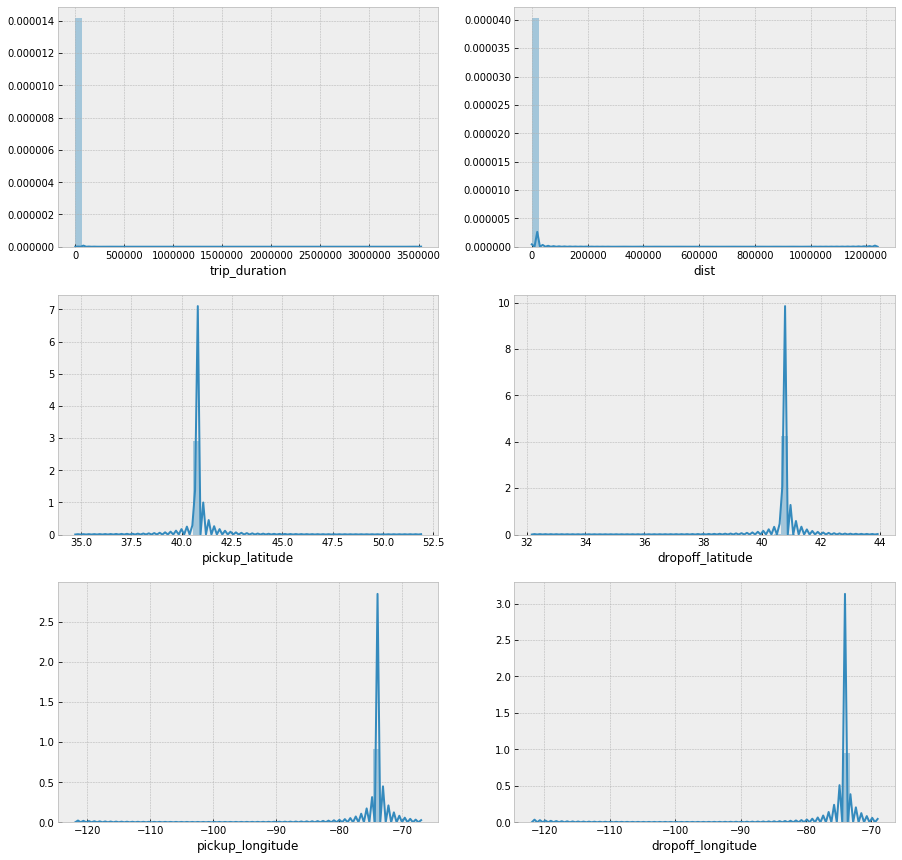

In [12]:
fig = plt.figure(1,figsize=(15,15))

ax1 = fig.add_subplot(321)
sb.distplot(data['trip_duration'])

ax2 = fig.add_subplot(322)
sb.distplot(data['dist'])

ax3 = fig.add_subplot(323)
sb.distplot(data['pickup_latitude'])

ax4 = fig.add_subplot(324)
sb.distplot(data['dropoff_latitude'])

ax5 = fig.add_subplot(325)
sb.distplot(data['pickup_longitude'])

ax6 = fig.add_subplot(326)
sb.distplot(data['dropoff_longitude'])

### 2.1 Distance

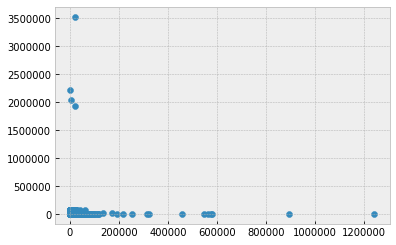

In [13]:
plt.scatter(data['dist'],data['trip_duration'])

#### 2.1.1 Feature scaling

Box-Cox vs. Logarithmic

In [8]:
data['log_trip_duration'] = np.log(data['trip_duration'])
data['bc_trip_duration'], _ = st.boxcox(data['trip_duration'])
data['log_dist'] = np.log(data['dist'])
data['bc_dist'], _ = st.boxcox(data['dist'])

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


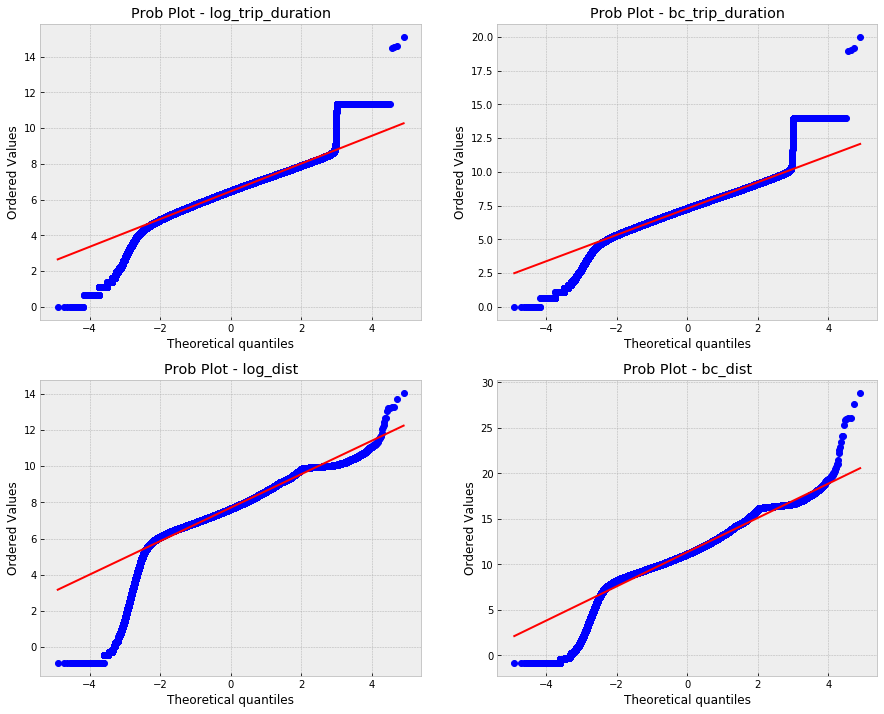

In [15]:
def prob_plot(data):    
    fig = plt.figure(1,figsize=(15,12))

    ax1 = fig.add_subplot(221)
    prob = st.probplot(data['log_trip_duration'], dist=st.norm, plot=ax1)
    ax1.set_title('Prob Plot - log_trip_duration')

    ax2 = fig.add_subplot(222)
    prob = st.probplot(data['bc_trip_duration'], dist=st.norm, plot=ax2)
    ax2.set_title('Prob Plot - bc_trip_duration')

    ax3 = fig.add_subplot(223)
    prob = st.probplot(data['log_dist'], dist=st.norm, plot=ax3)
    ax3.set_title('Prob Plot - log_dist')

    ax4 = fig.add_subplot(224)
    prob = st.probplot(data['bc_dist'], dist=st.norm, plot=ax4)
    ax4.set_title('Prob Plot - bc_dist')

    fig.show()

prob_plot(data)

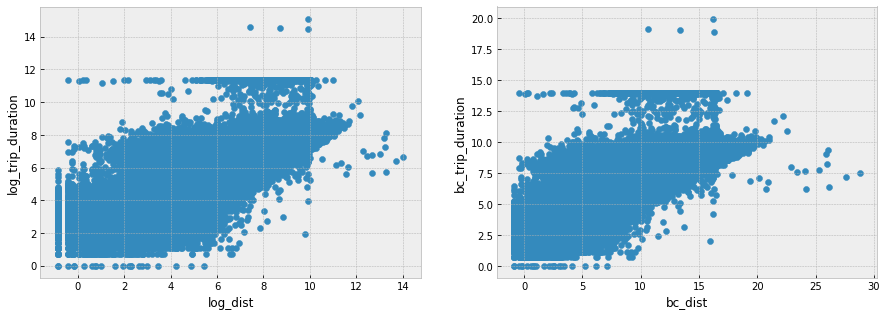

In [16]:
def scatter_combo(data):
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1.scatter(data['log_dist'].values,data['log_trip_duration'].values)
    ax1.set_xlabel('log_dist')
    ax1.set_ylabel('log_trip_duration')

    ax2 = fig.add_subplot(122)
    ax2.scatter(data['bc_dist'].values,data['bc_trip_duration'].values)
    ax2.set_xlabel('bc_dist')
    ax2.set_ylabel('bc_trip_duration')

scatter_combo(data)

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


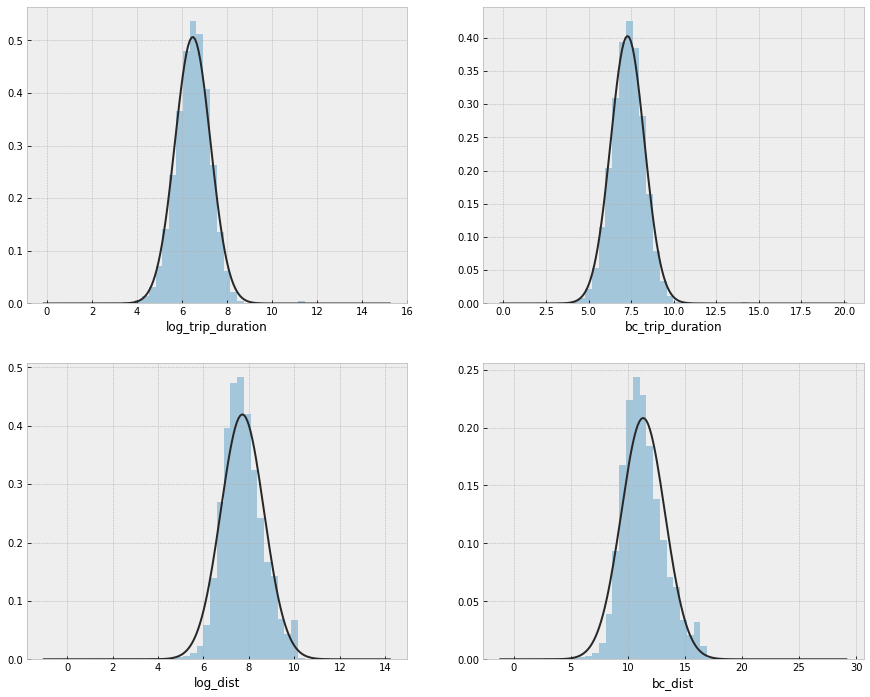

In [17]:
def dist_combo(data):    
    fig = plt.figure(figsize=(15,12))

    ax1 = fig.add_subplot(221)
    sb.distplot(data['log_trip_duration'],kde=False,fit=norm)

    ax2 = fig.add_subplot(222)
    sb.distplot(data['bc_trip_duration'],kde=False,fit=norm)

    ax3 = fig.add_subplot(223)
    sb.distplot(data['log_dist'],kde=False,fit=norm)

    ax4 = fig.add_subplot(224)
    sb.distplot(data['bc_dist'],kde=False,fit=norm)

    fig.show()

dist_combo(data)

It is not good to decide which transformation to perform. Perhaps, it is a good idea to treat the outliers first.

#### 2.1.2 Outliers detection

##### Visually

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


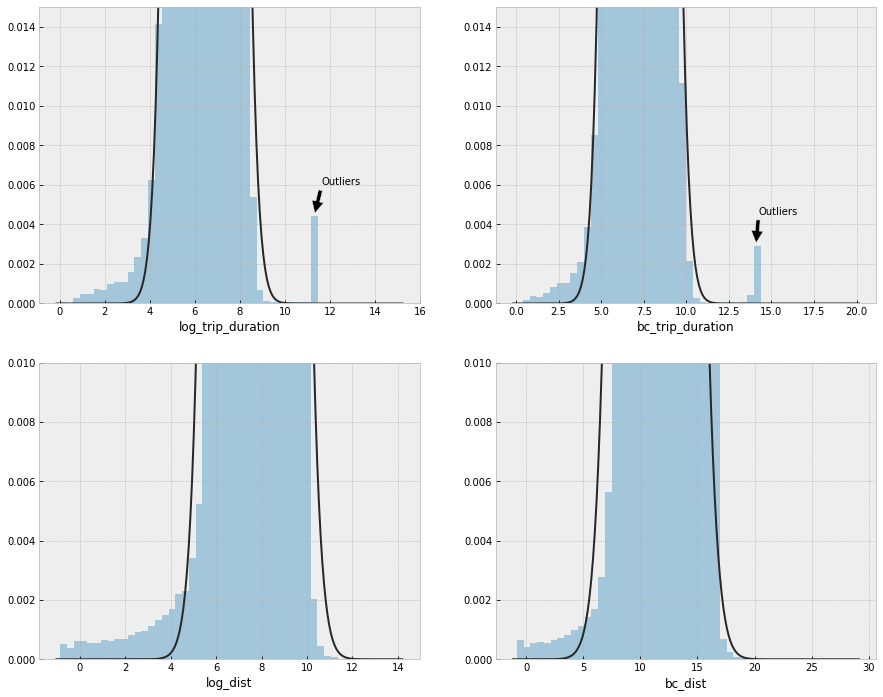

In [262]:
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(221)
data['log_trip_duration'] = np.log(data['trip_duration'])
sb.distplot(data['log_trip_duration'],kde=False,fit=norm)
ax1.set_ylim([0,0.015])
ax1.annotate('Outliers',
             xy=(data['log_trip_duration'][data['log_trip_duration']>10].mean(),0.0045),
             xytext=(data['log_trip_duration'][data['log_trip_duration']>10].mean()+0.3,0.006),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax2 = fig.add_subplot(222)
data['bc_trip_duration'], _ = st.boxcox(data['trip_duration'])
sb.distplot(data['bc_trip_duration'],kde=False,fit=norm)
ax2.set_ylim([0,0.015])
ax2.annotate('Outliers',
             xy=(data['bc_trip_duration'][data['log_trip_duration']>10].mean()+0.15,0.0030),
             xytext=(data['bc_trip_duration'][data['log_trip_duration']>10].mean()+0.3,0.0045),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax3 = fig.add_subplot(223)
data['log_dist'] = np.log(data['dist'])
sb.distplot(data['log_dist'],kde=False,fit=norm)
ax3.set_ylim([0,0.01])

ax4 = fig.add_subplot(224)
data['bc_dist'], _ = st.boxcox(data['dist'])
sb.distplot(data['bc_dist'],kde=False,fit=norm)
ax4.set_ylim([0,0.01])

fig.show()

In [263]:
print('The outliers average duration trip is of {:2.1f} hours.'.format(np.exp(data['log_trip_duration'][data['log_trip_duration']>10].mean())/3600.))

The outliers average duration trip is of 22.8 hours.


Is is most probable that these trips are actually the time in which the taxi didn't work. They will be discarded.

In [9]:
#Stores the index of the first set of outliers
idx_1 = data[data['log_trip_duration']>10].index

#Creates a new data frame whith the outliers
data1 = data[data['log_trip_duration']<=10].copy()

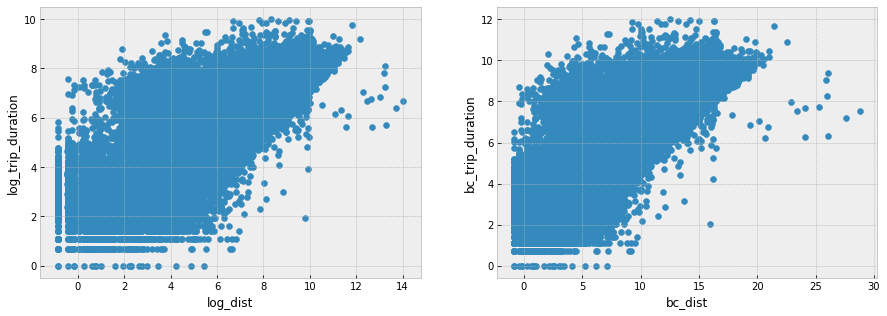

In [21]:
scatter_combo(data1)

##### Velocity limit

One should expect that there's a speed limit to the taxis. 

In [10]:
data1['vel'] = data1['dist']/data['trip_duration']*3.6

Text(0, 0.5, 'bc_trip_duration')

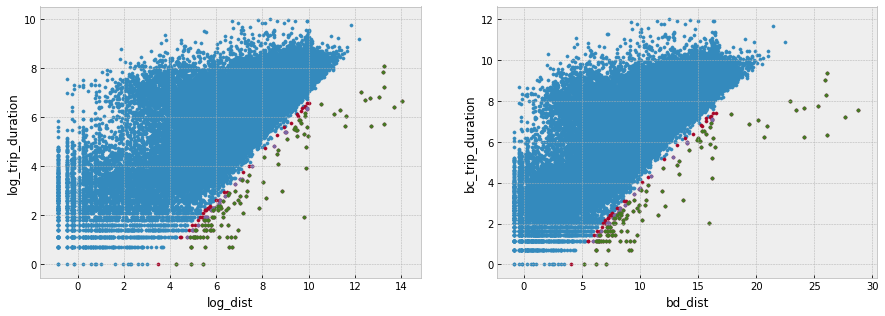

In [23]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data1['log_dist'][data1['vel']<100],data1['log_trip_duration'][data1['vel']<100],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>100],data1['log_trip_duration'][data1['vel']>100],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>120],data1['log_trip_duration'][data1['vel']>120],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>140],data1['log_trip_duration'][data1['vel']>140],s=10)
ax1.set_xlabel('log_dist')
ax1.set_ylabel('log_trip_duration')

ax2 = fig.add_subplot(122)
ax2.scatter(data1['bc_dist'][data1['vel']<100],data1['bc_trip_duration'][data1['vel']<100],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>100],data1['bc_trip_duration'][data1['vel']>100],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>120],data1['bc_trip_duration'][data1['vel']>120],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>140],data1['bc_trip_duration'][data1['vel']>140],s=10)
ax2.set_xlabel('bd_dist')
ax2.set_ylabel('bc_trip_duration')

It will be used 140km/h.

In [11]:
idx_2 = data1[data1['vel']>140].index

data2 = data1[data1['vel']<=140].copy()

#scatter_combo(data2)

##### Long distances limit

https://en.wikipedia.org/wiki/New_York_City


<img src="new_york_areamap.png" alt="drawing" width="500"/>

Text(151.5, 1, 'Outliers')

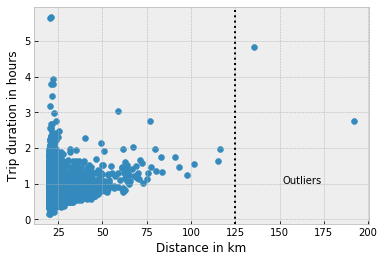

In [25]:
plt.scatter(data2['dist'][data2['dist']>20000]/1000,data2['trip_duration'][data2['dist']>20000]/3600)
plt.xlabel('Distance in km')
plt.ylabel('Trip duration in hours')

plt.axvline(125,linewidth=2, color='k',linestyle=':')
plt.annotate('Outliers',
             xy=(151.5,1),
             xytext=(151.5,1))

In [12]:
idx_3 = data2[data2['dist']>125000].index

data3 = data2[data2['dist']<=125000.].copy()

## 2.2 Latitude and Longitude

Text over why they are being considered here.

Text(0, 0.5, 'bc_trip_duration')

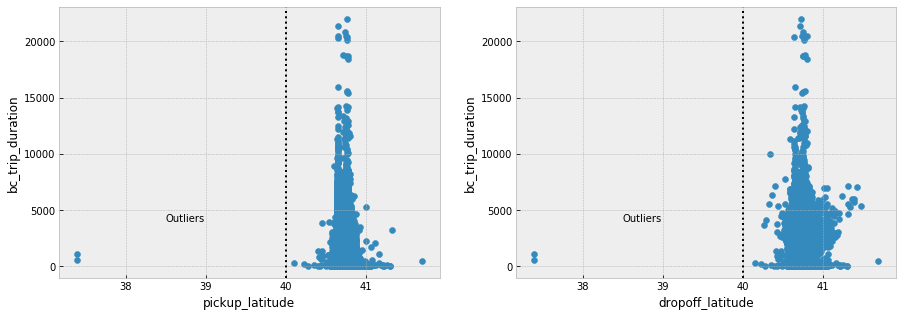

In [156]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data3['pickup_latitude'],data3['trip_duration'])
ax1.axvline(40,linewidth=2, color='k',linestyle=':')
ax1.annotate('Outliers',
             xy=(38,4000),
             xytext=(38.5,4000))
ax1.set_xlabel('pickup_latitude')
ax1.set_ylabel('bc_trip_duration')

ax2 = fig.add_subplot(122)
ax2.scatter(data3['dropoff_latitude'],data3['trip_duration'])
ax2.axvline(40,linewidth=2, color='k',linestyle=':')
ax2.annotate('Outliers',
             xy=(38,4000),
             xytext=(38.5,4000))
ax2.set_xlabel('dropoff_latitude')
ax2.set_ylabel('bc_trip_duration')

Text(0, 0.5, 'trip_duration')

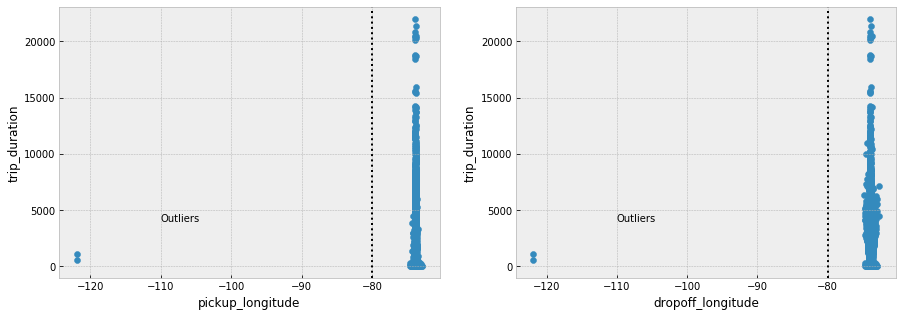

In [157]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data3['pickup_longitude'],data3['trip_duration'])
ax1.axvline(-80,linewidth=2, color='k',linestyle=':')
ax1.annotate('Outliers',
             xy=(-110,4000),
             xytext=(-110,4000))
ax1.set_xlabel('pickup_longitude')
ax1.set_ylabel('trip_duration')

ax2 = fig.add_subplot(122)
ax2.scatter(data3['dropoff_longitude'],data3['trip_duration'])
ax2.axvline(-80,linewidth=2, color='k',linestyle=':')
ax2.annotate('Outliers',
             xy=(-110,4000),
             xytext=(-110,4000))
ax2.set_xlabel('dropoff_longitude')
ax2.set_ylabel('trip_duration')

In [13]:
idx_4 = data3[(data3['pickup_latitude']<40)|(data3['pickup_latitude']<40)|(data3['pickup_longitude']<-80)|(data3['pickup_longitude']<-80)].index

data4 = data3[~((data3['pickup_latitude']<40)|(data3['pickup_latitude']<40)|(data3['pickup_longitude']<-80)|(data3['pickup_longitude']<-80))].copy()

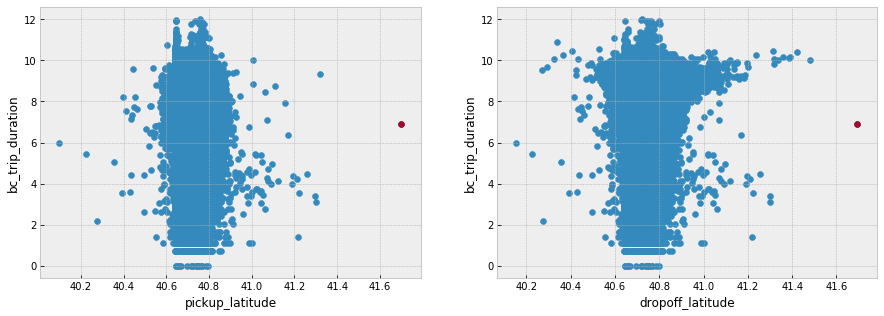

In [159]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data4['pickup_latitude'],data4['bc_trip_duration'])
#ax1.axvline(40,linewidth=2, color='k',linestyle=':')
#ax1.annotate('Outliers',
#             xy=(38,4000),
#             xytext=(38.5,4000))
ax1.set_xlabel('pickup_latitude')
ax1.set_ylabel('bc_trip_duration')
ax1.scatter(data4['pickup_latitude'][data4['pickup_latitude']>41.6],data4['bc_trip_duration'][data4['pickup_latitude']>41.6])

ax2 = fig.add_subplot(122)
ax2.scatter(data4['dropoff_latitude'],data4['bc_trip_duration'])
#ax2.axvline(40,linewidth=2, color='k',linestyle=':')
#ax2.annotate('Outliers',
#             xy=(38,4000),
#             xytext=(38.5,4000))
ax2.set_xlabel('dropoff_latitude')
ax2.set_ylabel('bc_trip_duration')
ax2.scatter(data4['dropoff_latitude'][data4['pickup_latitude']>41.6],data4['bc_trip_duration'][data4['pickup_latitude']>41.6])

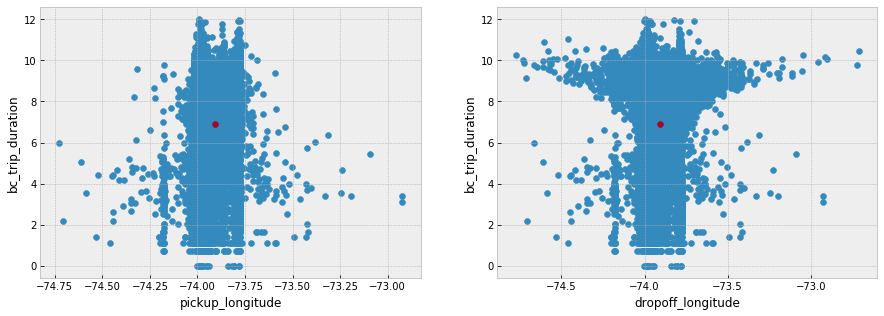

In [160]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data4['pickup_longitude'],data4['bc_trip_duration'])
#ax1.axvline(-80,linewidth=2, color='k',linestyle=':')
#ax1.annotate('Outliers',
#             xy=(-110,4000),
#             xytext=(-110,4000))
ax1.set_xlabel('pickup_longitude')
ax1.set_ylabel('bc_trip_duration')
#Add the outlier from latitude with another collor
ax1.scatter(data4['pickup_longitude'][data4['pickup_latitude']>41.6],data4['bc_trip_duration'][data4['pickup_latitude']>41.6])

ax2 = fig.add_subplot(122)
ax2.scatter(data4['dropoff_longitude'],data4['bc_trip_duration'])
#ax2.axvline(-80,linewidth=2, color='k',linestyle=':')
#ax2.annotate('Outliers',
#             xy=(-110,4000),
#             xytext=(-110,4000))
ax2.set_xlabel('dropoff_longitude')
ax2.set_ylabel('bc_trip_duration')
#Add the outlier from latitude with another collor
ax2.scatter(data4['dropoff_longitude'][data4['pickup_latitude']>41.6],data4['bc_trip_duration'][data4['pickup_latitude']>41.6])

In [236]:
data4[['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude']][data4['pickup_latitude']>41.6]

,pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude
837346,41.696796,41.693352,-73.905724,-73.904854


Both points (pickup and dropoff) are in Arlington and will be removed.

<img src="arlington.png" alt="drawing" width="500"/>
<img src="arlington2.png" alt="drawing" width="500"/>

In [14]:
idx_5 = data4[data4['pickup_latitude']>41.6].index

data5 = data4[~(data4['pickup_latitude']>41.6)].copy()

Text(0, 0.5, 'bc_trip_duration')

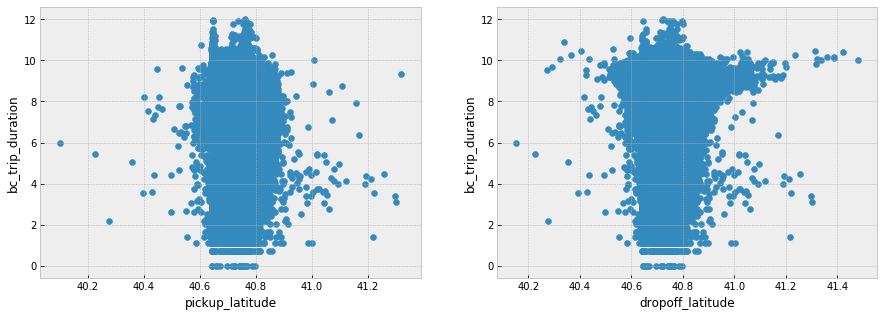

In [167]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data5['pickup_latitude'],data5['bc_trip_duration'])
#ax1.axvline(40,linewidth=2, color='k',linestyle=':')
#ax1.annotate('Outliers',
#             xy=(38,4000),
#             xytext=(38.5,4000))
ax1.set_xlabel('pickup_latitude')
ax1.set_ylabel('bc_trip_duration')

ax2 = fig.add_subplot(122)
ax2.scatter(data5['dropoff_latitude'],data5['bc_trip_duration'])
#ax2.axvline(40,linewidth=2, color='k',linestyle=':')
#ax2.annotate('Outliers',
#             xy=(38,4000),
#             xytext=(38.5,4000))
ax2.set_xlabel('dropoff_latitude')
ax2.set_ylabel('bc_trip_duration')

#### 2.1.3 Finalizing feature scaling

Updating the Box-Cox transformation after all the outliers removal.

In [15]:
data5['bc_trip_duration'], lambda_tripduration = st.boxcox(data5['trip_duration'])
data5['bc_dist'], lambda_dist = st.boxcox(data5['dist'])

Normalizing the data.

In [16]:
scaler = MinMaxScaler()

numerical = ['pickup_longitude',
             'pickup_latitude',
             'dropoff_longitude',
             'dropoff_latitude',
             'bc_dist',
             'log_dist',
             'bc_trip_duration',
             'log_trip_duration']

data5[numerical] = scaler.fit_transform(data5[numerical])

scale = {x : [] for x in numerical}
for idx,col in enumerate(numerical):
    scale[col] = scaler.scale_[idx]
    
mint = {x : [] for x in numerical}
for idx,col in enumerate(numerical):
    mint[col] = scaler.data_min_[idx]

```python
X_scaled = scale * X + min - X.min(axis=0) * scale
X = (X_scaled - min) / scale + X.min(axis=0)

scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
min,max = min,max(feature_range)
feature_range = (0,1) - Default
```

### 2.2 Time related characteristics

#### 2.2.1 Weekday, holiday, special day events and hour influences

In [17]:
from datetime import date
import holidays

ny_holidays = holidays.UnitedStates(state='NY')
ny_holidays = ny_holidays[data5['pickup_datetime'].dt.date.min(): data5['pickup_datetime'].dt.date.max()]

data5['week_day'] = data5['pickup_datetime'].dt.weekday_name

#New York Holiday
data5['holiday'] = 0
data5['holiday'] = np.where(data5['pickup_datetime'].dt.date.isin(ny_holidays),
                            1,
                            0)
#Special Events
## New Year's Day 1/1/2016
## St. Patrick's Day 17/3/2016
## Valentine's Day 12/2/2016
data5['special'] = 0
data5['special'] = np.where(data5['pickup_datetime'].dt.date.isin([date(2016,1,1),date(2016,3,17),date(2016,2,12)]),
                            1,
                            0)
#Time for ciclical behaviour
data5['hour'] = data5['pickup_datetime'].dt.hour
data5['day'] = data5['pickup_datetime'].dt.day
data5['month'] = data5['pickup_datetime'].dt.month

Text(0.5, 1.0, 'Special=0; Holiday=0')

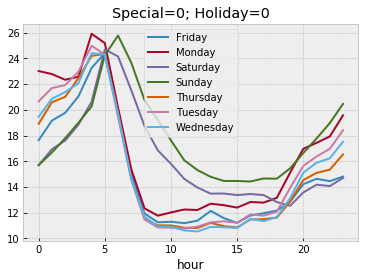

In [382]:
days = data5[['vel','trip_duration','hour','week_day','holiday','special']].groupby(['hour','week_day','holiday','special']).agg('mean').reset_index(drop=False)

plt.figure(1)
for wd in days['week_day'][(days['holiday']==0)&(days['special']==0)].unique():
    plt.plot(days['hour'][(days['week_day']==wd)&(days['holiday']==0)&(days['special']==0)],
             days['vel'][(days['week_day']==wd)&(days['holiday']==0)&(days['special']==0)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special=0; Holiday=0')

Text(0.5, 1.0, 'Special=1; Holiday=1')

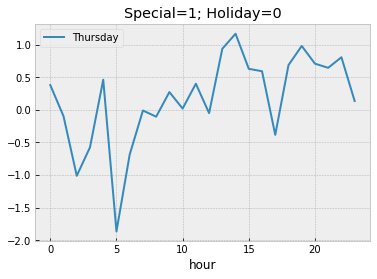

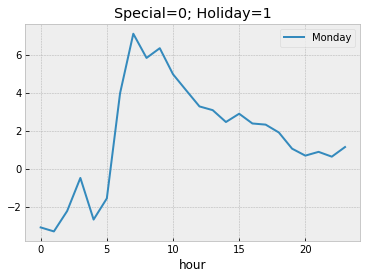

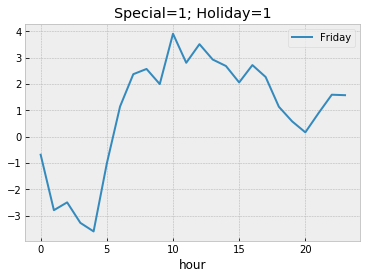

In [383]:
non_special = pd.merge(days[~((days['special']==0)&(days['holiday']==0))],
                       days[['week_day','hour','vel']][((days['special']==0)&(days['holiday']==0))],
                       right_on=['week_day','hour'],
                       left_on=['week_day','hour'],
                       how='left')
non_special['vel_dif'] = non_special['vel_x'] - non_special['vel_y']

s = 1
h = 0
plt.figure(1)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

s = 0
h = 1
plt.figure(2)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

s = 1
h = 1
plt.figure(3)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

#### 2.2.2 Day of the month influence

Text(0, 0.5, 'average_velocity')

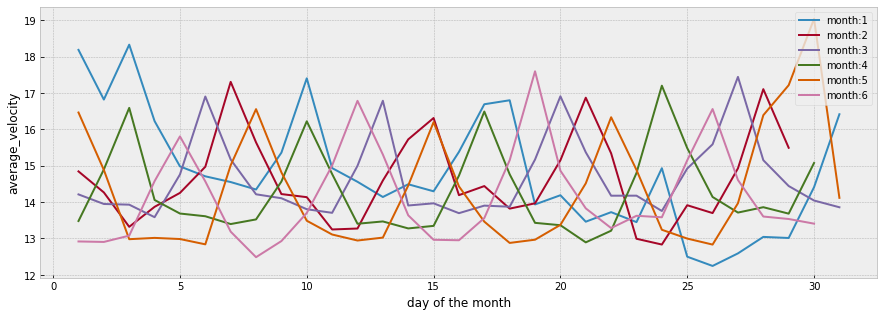

In [384]:
avg = data5[['vel','trip_duration','day','month']].groupby(['day','month']).agg('mean').reset_index(drop=False)

plt.figure(figsize=(15,5))
for month in avg['month'].unique():
    plt.plot(avg['day'][avg['month']==month],avg['vel'][avg['month']==month],label='month:' + str(month))

plt.legend()
plt.xlabel('day of the month')
plt.ylabel('average_velocity')

#### 2.2.3 Month influence

Text(0, 0.5, 'average_velocity')

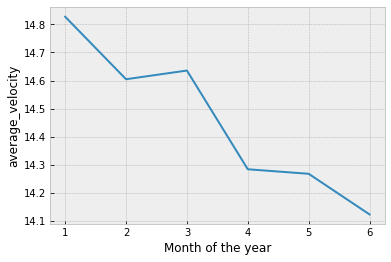

In [385]:
avg = data5[['vel','trip_duration','month']].groupby(['month']).agg('mean').reset_index(drop=False)

plt.plot(avg['month'],avg['vel'])
plt.xlabel('Month of the year')
plt.ylabel('average_velocity')

### 2.3 Other influences

#### 2.3.1 Vendor

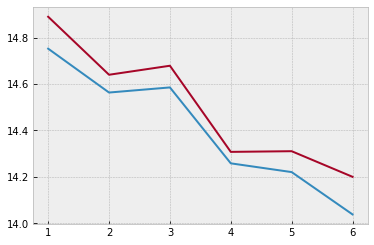

In [386]:
def plot_feature(data5,featurex,featurey,featurez):
    avg = data5[[featurey,featurex,featurez]].groupby([featurex,featurez]).agg('mean').reset_index(drop=False)

    plt.plot(avg[featurex][avg[featurez]==avg[featurez].unique()[0]],avg[featurey][avg[featurez]==avg[featurez].unique()[0]],label='average')
    plt.plot(avg[featurex][avg[featurez]==avg[featurez].unique()[1]],avg[featurey][avg[featurez]==avg[featurez].unique()[1]],label='average')

plot_feature(data5,'month','vel','vendor_id')

#### 2.3.2 Passenger count

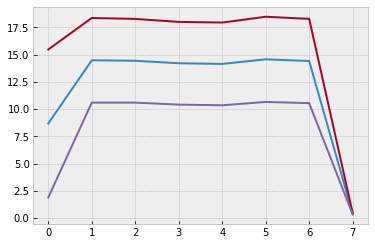

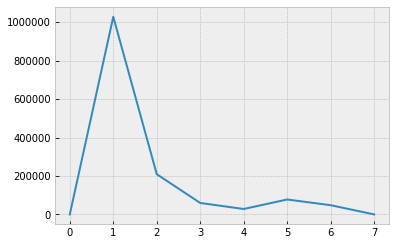

In [387]:
avg = data5[['vel','passenger_count']].groupby(['passenger_count']).agg('mean').reset_index(drop=False)
std = data5[['vel','passenger_count']].groupby(['passenger_count']).agg('std').reset_index(drop=False)

plt.figure(1)
plt.plot(avg['passenger_count'],avg['vel'],label='average')
plt.plot(avg['passenger_count'],avg['vel']+std['vel']/2,label='average')
plt.plot(avg['passenger_count'],avg['vel']-std['vel']/2,label='average')

data5['count'] = 1
count = data5[['count','passenger_count']].groupby(['passenger_count']).agg('sum').reset_index(drop=False)

plt.figure(2)
plt.plot(count['passenger_count'],count['count'])

del data5['count']

In [433]:
print('There are {} observations with 0 passengers'.format(len(data5[data5['passenger_count']==0])))
print('There are {} observations with 7 passengers'.format(len(data5[data5['passenger_count']==7])))

There are 50 observations with 0 passengers
There are 2 observations with 7 passengers


As they are not big samples, the reason the average velocity is diferent is because the sample are biased. The observations with other number of passanger do not depend on the number of passengers. That's why this feature will be disconsiderd. This is reasanable because one shouldn't expect that the drip duration would depend on passenger counting.

In [18]:
data5 = data5.drop(columns='passenger_count')

#### 2.3.3 store_and_fwd_flag

In [19]:
plot_feature(data5,'month','vel','store_and_fwd_flag')

NameError: name 'plot_feature' is not defined

#### 2.3.4 Treating those dependencies

Considered all categorical data. Will be tranformed by one-hot-encoding.

In [20]:
data5 = pd.get_dummies(data5,columns=['vendor_id',
                                      'store_and_fwd_flag',
                                      'holiday',
                                      'special',
                                      'week_day',
                                      'hour',
                                      'day',
                                      'month'])

del data5['pickup_datetime']
del data5['vel']

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


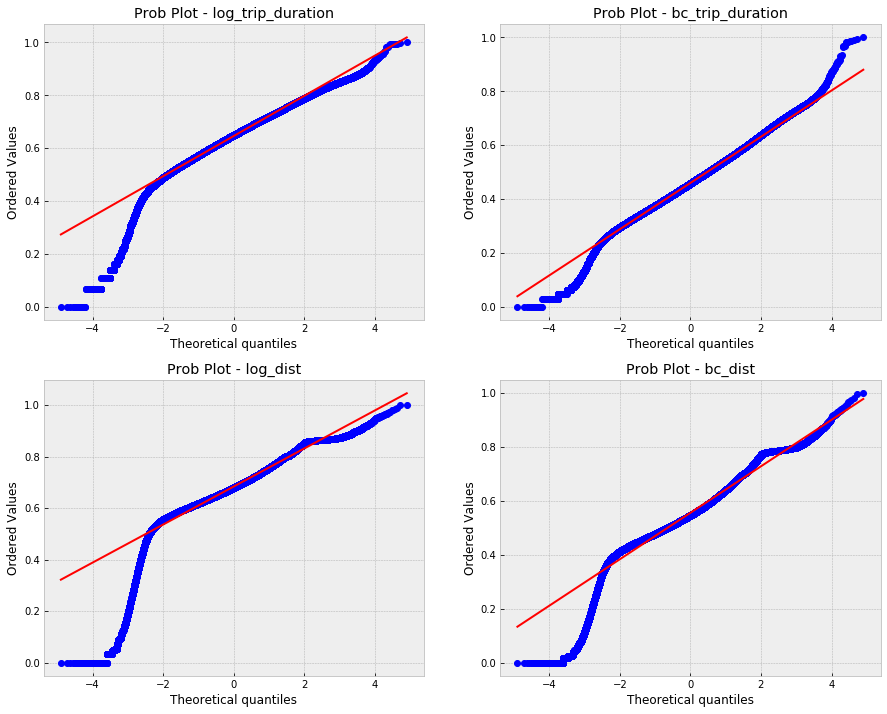

In [786]:
prob_plot(data5)

## 3. Model picking

### 3.1 Transform: Logarithmic or Box-Cox 

In [21]:
#bc for Box-Cox transformation
transform = 'log'

if transform == 'bc':
    data6 = data5.drop(columns=['log_dist','log_trip_duration','dist','trip_duration'])
else:
    data6 = data5.drop(columns=['bc_dist','bc_trip_duration','dist','trip_duration'])
    
Y = data6[transform+'_trip_duration']
X = data6.drop(columns=[transform+'_trip_duration'])

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X,
                                                Y,
                                                test_size = 0.3,
                                                random_state = 42)

### 3.1 Model picking - Which regressor?

In [897]:
from sklearn.model_selection import KFold
from collections import defaultdict
import time


def train_predict_crossval(regressors, x, y, transform, scale, mint, n_splits=1, sample_size=0.05): 
    '''
    inputs:
       - regressors: list of all initialized regressors to be trained
       - data: dataframe with all the data (target and features)
       - transform: 'log' (for log transformation) or 'bc' (for Box-Cox transformation)
       - scale: dict with all the scales from the Box-Cox transformation
       - mint: dict with all the minima from the Box-Cox transformation
       - n_splits: number of splits for the cross validation
       - sample_size: list of float with the size of samples (frac) to be drawn from training set
    '''

    results = defaultdict(lambda: [None for i in range(n_splits*len(regressors)*len(sample_size))])

    kf = KFold(n_splits=n_splits,shuffle=True)
    
    count = 0
    for s in sample_size:

        y1 = y.sample(n=None,frac=s,random_state=42).values
        x1 = x.sample(n=None,frac=s,random_state=42).values

        for idx, regressor in enumerate(regressors):

            split = 0
            for train_index, test_index in kf.split(x1):

                #Train
                start = time.time()
                regressor.fit(x1[train_index,:],
                              y1[train_index])
                end = time.time()
                results['train_time'][count] = end - start

                #Test
                start = time.time()
                prediction_test = regressor.predict(x1[test_index,:])

                train_sample_index = np.random.permutation(np.arange(len(train_index)))
                prediction_train = regressor.predict(x1[train_index,:][train_sample_index[:len(test_index)],:])
                end = time.time()
                results['pred_time'][count] = end - start

                #Storaging the results
                results['RMSLE_test'][count] = RMSLE(y1[test_index],
                                                     prediction_test,
                                                     transform,
                                                     scale,
                                                     mint)
                results['RMSLE_train'][count] = RMSLE(y1[train_index][train_sample_index[:len(test_index)]],
                                                      prediction_train,
                                                      transform,
                                                      scale,
                                                      mint)

                results['regressor'][count] = regressor.__class__.__name__

                results['sample_size'][count] = s

                print("{} trained on {} samples (split {})".format(regressor.__class__.__name__,x1[train_index,:].shape[0],split))

                split+=1
                count+=1

    # Return the results
    return results

In [777]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb

#List of regressors
regressors = [LinearRegression(),
              BaggingRegressor(random_state=42),
              RandomForestRegressor(random_state=42),
              GradientBoostingRegressor(random_state=42),
              xgb.XGBRegressor(random_state=42)]

results = train_predict_crossval(regressors, xtrain, ytrain, transform, scale, mint,n_splits=2,sample_size=[0.05, 0.1])

LinearRegression trained on 25385 samples (split 0)
LinearRegression trained on 25385 samples (split 1)
BaggingRegressor trained on 25385 samples (split 0)
BaggingRegressor trained on 25385 samples (split 1)


C:\Users\Cora\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor trained on 25385 samples (split 0)
RandomForestRegressor trained on 25385 samples (split 1)
GradientBoostingRegressor trained on 25385 samples (split 0)
GradientBoostingRegressor trained on 25385 samples (split 1)
[13:08:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 25385 samples (split 0)
[13:08:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 25385 samples (split 1)
LinearRegression trained on 50770 samples (split 0)
LinearRegression trained on 50770 samples (split 1)
BaggingRegressor trained on 50770 samples (split 0)
BaggingRegressor trained on 50770 samples (split 1)
RandomForestRegressor trained on 50770 samples (split 0)
RandomForestRegressor trained on 50770 samples (split 1)
GradientBoostingRe

In [778]:
aux = pd.DataFrame(results).groupby(['regressor','sample_size']).agg('mean').reset_index(drop=False)

In [22]:
from matplotlib import cm

fig = plt.figure(figsize = (13,8))
bar_width = 0.085
colors = cm.plasma(np.linspace(1,255,len(regressors)).astype(int))

for r, regressor, in enumerate(regressors):
    for s,sample in enumerate(aux['sample_size'].unique()):
        if s < len(aux['sample_size'].unique())-1:
            plt.bar(s/2+r*bar_width,
                    aux['RMSLE_train'][(aux['regressor']==regressor.__class__.__name__)],
                    width = bar_width,
                    color = colors[r],
                    alpha=0.3)

            plt.bar(s/2+r*bar_width,
                    (aux['RMSLE_test']-aux['RMSLE_train'])[(aux['regressor']==regressor.__class__.__name__)],
                    width = bar_width,
                    color = colors[r],
                    bottom=aux['RMSLE_train'][(aux['regressor']==regressor.__class__.__name__)])
        else:
            plt.bar(s/2+r*bar_width,
                    aux['RMSLE_train'][(aux['regressor']==regressor.__class__.__name__)],
                    width = bar_width,
                    color = colors[r],
                    alpha=0.3,
                    label='CV Train - '+regressor.__class__.__name__)

            plt.bar(s/2+r*bar_width,
                    (aux['RMSLE_test']-aux['RMSLE_train'])[(aux['regressor']==regressor.__class__.__name__)],
                    width = bar_width,
                    color = colors[r],
                    bottom=aux['RMSLE_train'][(aux['regressor']==regressor.__class__.__name__)],
                    label='CV Test - '+regressor.__class__.__name__)

ticks = [np.mean(s/2+bar_width * np.arange(len(regressors))) for s, sample_size in enumerate(aux['sample_size'].unique())]
ticklables = [str(int(np.round(sample_size*100,0)))+'% of total dataset.' for s, sample_size in enumerate(aux['sample_size'].unique())] 

plt.legend(bbox_to_anchor=(0.999, 1))

plt.xticks(ticks,ticktables,fontsize=14)
plt.ylabel('RMSL',fontsize=14)

NameError: name 'regressors' is not defined

<Figure size 936x576 with 0 Axes>

### 3.2 Model picking: fine tunning

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error
from custom_score_fun import RMSLE

from matplotlib import cm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
import numpy as np

scorer = make_scorer(RMSLE,transform=transform,scale=scale,mint=mint, greater_is_better= False)

regressors = [xgb.XGBRegressor(random_state=0,reg='squaredlogerror'),
              GradientBoostingRegressor(random_state=42)]

parameters = {regressors[0].__class__.__name__: {'max_depth': [4,5,6], 'n_estimators': [50,100,200], 'reg_lambda': [0.1] },
              
              regressors[1].__class__.__name__: {'max_depth': [4,5,6], 'n_estimators': [50,100,200]}}

results = {}
for regressor in regressors:
    
    model = GridSearchCV(regressor, 
                         param_grid= parameters[regressor.__class__.__name__], 
                         scoring= scorer, 
                         verbose= 1, 
                         n_jobs= -1, 
                         cv=2,
                         return_train_score=True)

    grid_fit = model.fit(xtrain.sample(n=None,frac=0.05,random_state=42).values, 
                         ytrain.sample(n=None,frac=0.05,random_state=42).values)

    results[regressor.__class__.__name__] = {}
    results[regressor.__class__.__name__]['params'] = grid_fit.cv_results_['params']
    results[regressor.__class__.__name__]['mean_train_score'] = -grid_fit.cv_results_['mean_train_score']
    results[regressor.__class__.__name__]['mean_test_score'] = -grid_fit.cv_results_['mean_test_score']


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s finished


[17:45:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Cora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.5s finished
C:\Users\Cora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


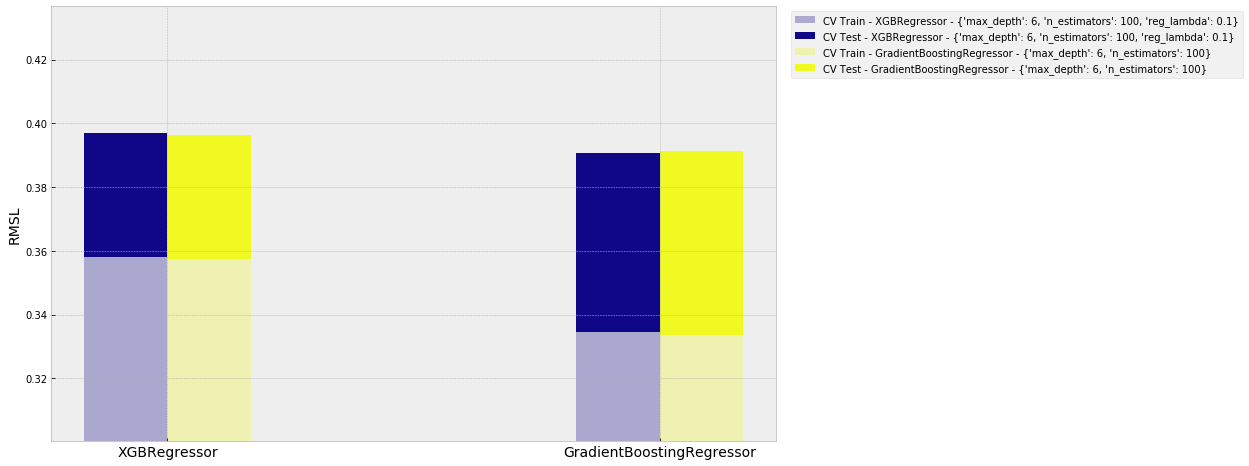

In [64]:
from matplotlib import cm

fig = plt.figure(figsize = (13,8))
bar_width = 0.085
colors = cm.plasma(np.linspace(1,255,len(regressors)).astype(int))

for r, regressor, in enumerate(regressors):
    for p,params in enumerate(results[regressor.__class__.__name__]['params']):
        if p < len(results[regressor.__class__.__name__]['params'])-1:
            plt.bar(p/2+r*bar_width,
                    results[regressor.__class__.__name__]['mean_train_score'][p],
                    width = bar_width,
                    color = colors[r],
                    alpha=0.3)

            plt.bar(p/2+r*bar_width,
                    results[regressor.__class__.__name__]['mean_test_score'][p]-results[regressor.__class__.__name__]['mean_train_score'][p],
                    width = bar_width,
                    color = colors[r],
                    bottom=results[regressor.__class__.__name__]['mean_train_score'][p])
        else:
            plt.bar(p/2+r*bar_width,
                    results[regressor.__class__.__name__]['mean_train_score'][p],
                    width = bar_width,
                    color = colors[r],
                    alpha=0.3,
                    label='CV Train - '+regressor.__class__.__name__ + ' - ' + str(results[regressor.__class__.__name__]['params'][p]))

            plt.bar(p/2+r*bar_width,
                    results[regressor.__class__.__name__]['mean_test_score'][p]-results[regressor.__class__.__name__]['mean_train_score'][p],
                    width = bar_width,
                    color = colors[r],
                    bottom=results[regressor.__class__.__name__]['mean_train_score'][p],
                    label='CV Test - '+regressor.__class__.__name__ + ' - ' + str(results[regressor.__class__.__name__]['params'][p]))

ticks = [np.mean(r/2+bar_width * np.arange(len(regressors))) for r, regressor, in enumerate(regressors)]
ticklables = [regressor.__class__.__name__ for r, regressor, in enumerate(regressors)] 

plt.xticks(ticks,ticklables,fontsize=14)
plt.ylabel('RMSL',fontsize=14)
plt.ylim([0.9 * min([min(results[regressor.__class__.__name__]['mean_train_score']) for regressor in (regressors)]),
         1.1 * max([max(results[regressor.__class__.__name__]['mean_test_score']) for regressor in (regressors)])])

plt.legend(bbox_to_anchor=(1.65, 1))